# Comparing meta-learners with different ensembles of trees as base learners

## Introduction

When estimating causal effect of a certain treatment, generally we cannot assume that all of the treated units will respond to the treatement in the same way, that is the causal effect is might be *heterogeneous*. For example, the effectiveness of a certain medication might depend on the patient's age, gender, medical history, etc.. Estimating the treatement effect conditional to a set of covariates can provide valuable insights into our data. In this notebook we give a brief introduction to *meta-learners*, a class of models for estimating heterogeneous causal effect by leveraging machine learning methods.

For a deeper dive on meta-learners we suggest reading [[1]](https://arxiv.org/abs/1706.03461) or for a lighter overview in video format, check out [Causal Effects via Regression by Shawhin Talebi](https://youtu.be/O72uByJlnMw). We also highly recommend reading Causal Inference for The Brave and True by Matheus Facure Alves [[3]](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) for an easily digestible, yet comprehensive guide on several estimators discussed in this notebook.

We will denote by $Y$ a $d$-dimensional outcome vector, by $X \in \mathbb{R}^{d \times n}$ a feature matrix containing potential confounders, by $W \in \{0, 1\}^d$ the treatment assignment indicator and by  $Y(0) \in \mathbb{R}^d$ and $Y(1) \in \mathbb{R}^d$ the potential outcome of corresponding units when assigned to the control and the treatement group respectively. Note that
$$ Y = W Y(1) + (1 - W) Y(0).$$

Our task is to estimate the *conditional average treatement effect (CATE)*, defined as 
$$\tau(x) = \mathbb{E}\left[Y(1) - Y(0) \mid X=x\right].$$

Since only one of the potential outcomes materializes, CATE is never directly observed, this is often refered to as *the fundamental problem of causal inference*. Meta-learners estimate CATE by decomposing the treatement effect estimation to several subregressions. For instance the one may estimate $Y(0)$ and $Y(1)$ in two separate regressions and estimate CATE as the difference of the two functions (this is the approach of the T-learner discussed later). The estimators used for these subregressions are called *base learners*. Some of the most popular base learners are tree based ensembles, in particular Random Forest and Bayesian Additive Regression Trees (BART) due to their flexibility, however any machine learning algorithm suitable for regression problems (like generalized linear regressions, gaussian processes, etc.) can be used.

## Assumptions
As always, in order to be able to derive meaningful results, we need to impose some untestable assumptions. 
1. __(Consistency)__: If the $i$th unit is assigned to the treated group, in other words $W_i=1$, then $Y_i(1)$ is observed and $Y_i(0)$ is observed otherwise.
2. __(Unconfoundedness)__: The treatement assignment $W_i$ is independent from $Y_i(0)$ and $Y_i(1)$ conditional on $X_i$, that is
$$Y_i(0), Y_i(1) \perp\!\!\!\perp W_i\mid X_i.$$
3. __(Overlap)__: $0 < \mathbb{P}(W_i = 1 \mid X_i=x) < 1$, i.e. treatement assignment is non-deterministic.

Given these assumptions, $\tau(x)$ can be written as the difference of the expected values observed random variables, namely
$$\tau(x) = \mathbb{E}[Y(1) \mid X=x, W=1] - \mathbb{E}[Y(0) \mid X=x, W=0].$$

## Data generation

In this notebook we will deal with synthetic data, so that we can quantify exactly the mean squared error of our CATE estimations. The data generating is of the form
$$y = \operatorname{sinc}(\alpha X) + W \sigma(\beta X) + \varepsilon,$$
where $\varepsilon_i \sim N(0, 1)$ and $W_i \sim \operatorname{Bernoulli}\left(\frac14\right)$ are i.i.d., $$\sigma(x) = \frac{e^x}{1 + e^x}, \quad \text{and} \quad \operatorname{sinc}(x) = \frac{\sin(x)}{x}$$ are applied coordinate-wise.

Here, CATE can be expressed as $$\tau(X) = \sigma(\beta X).$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBClassifier, XGBRegressor

from causalpy.skl_meta_learners import DRLearner, SLearner, TLearner, XLearner

np.random.seed(42)


def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))


def sinc(x):
    return np.where(x == 0, 1, np.sin(x) / x)


def create_synthetic_data(*shape):
    X = np.random.rand(*shape)

    α = np.random.rand(shape[1])
    β = np.random.rand(shape[1])

    treatment = np.random.binomial(n=1, p=0.25, size=shape[0])
    treatment_effect = sigmoid(X @ β)

    noise = np.random.rand(shape[0])

    y = sinc(X @ α) + treatment_effect * treatment + noise

    X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(shape[1])])
    y = pd.Series(y, name="target")
    treated = pd.Series(treatment, name="treatment")
    return X, y, treated, treatment_effect


X, y, treated, treatment_effect = create_synthetic_data(100, 5)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Model evaluation
The summary method of a scikit-learn based meta-learner contains
* Number of observations,
* number of treated observations,
* average treatement effect (ATE),
* 95% Confidence interval for ATE,
* estimated bias,
* in-sample $R^2$. 

Confidence intervals and bias are calculated when summary is called via bootstrapping. This means that the runtime of each learner in these examples will be exaggerated. 

In [2]:
def summarize_learner(learner):
    learner.summary(n_iter=100)
    print(f"Actual average treatement effect: {treatment_effect.mean()}")
    print(f"MSE: {mean_squared_error(treatment_effect, learner.cate)}")
    learner.average_uplift_by_percentile(X).plot()

## S-learner

The simplest meta-learner is the *S-learner*, which predicts the potential outcome vectors by treating the treatement assignment indicator as a feature and estimates

$$\mu(x, w) := \mathbb{E}[Y \mid X=x, W=w]$$

with an appropriate base learner. The "S" in S-learner stands for "single", as it uses a single model to estimate CATE. We will denote this estimation with $\hat{\mu}(x, w)$. Then the S-learner approximates CATE as  

$$\hat{\tau_S}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0).$$

In the following example we will choose `HistGradientBoostingRegressor` as base learner.

Number of observations:             100
Number of treated observations:     26
Average treatement effect (ATE):    0.7573144867185623
95% Confidence interval for ATE:    (0.6551374637321661, 1.1244220824288043)
Estimated bias:                     -0.015414836797426407
---- Score  ----
{'model': 0.7407260838009135}
Actual average treatement effect: 0.8455644128466571
MSE: 0.012366285859837036
CPU times: total: 1min 26s
Wall time: 11.5 s


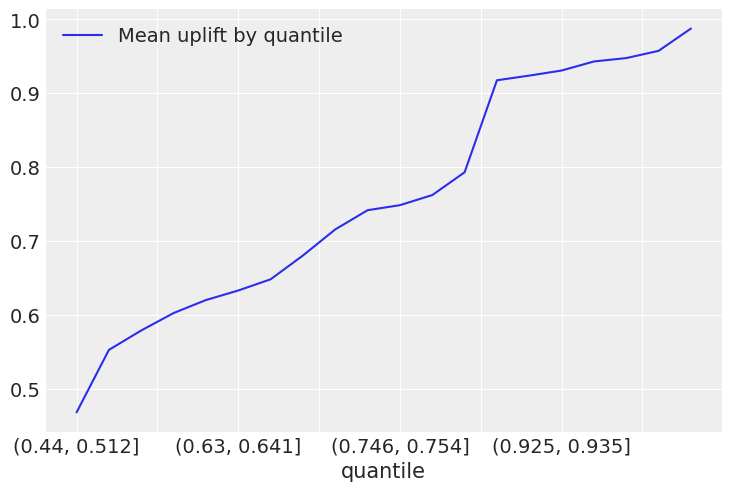

In [3]:
%%time
# Utility for printing some statistics.
slearner = SLearner(X=X, y=y, treated=treated, model=HistGradientBoostingRegressor())

summarize_learner(slearner)

## T-learner

The *T-learner* is a closely related meta-learner. Here, instead of including the treatment assignment indicator as a feature, we estimate the potential outcomes in two different regressions. Namely, we estimate
$$\mu_{\operatorname{treated}}(x) := \mathbb{E}[Y(1) \mid X=x], \quad \text{and} \quad \mu_{\operatorname{untreated}}(x) := \mathbb{E}[Y(0) \mid X=x]$$
separately and define estimate the cate as
$$\hat{\tau}_T(x) = \hat{\mu}_{\operatorname{treated}}(x) - \hat{\mu}_{\operatorname{untreated}}(x),$$
where $\hat{\mu}_{\operatorname{treated}}$ and $\hat{\mu}_{\operatorname{untreated}}$ are the estimated functions. 

If we choose our base-learners to be a forest based ensemble, in the case of the S-learner, during the fitting process splits on the treatement assignment indicator can happen *anywhere* in the trees. In the fitting process of the T-learner however, we essentially force a split at the first level. This difference means that the S-learner is more flexible, but especially when using regularization, it is prone to disregard the effect of the treatment. On the other hand the T-learner uses two separate models that do not share information between each other, which may lead to overfitting if one of the treatement groups is small.

Number of observations:             100
Number of treated observations:     26
Average treatement effect (ATE):    0.9696548539528407
95% Confidence interval for ATE:    (0.6260569983725455, 1.380766593414531)
Estimated bias:                     0.0018099847967227778
---- Score  ----
{'treated': -0.05211016280333158, 'untreated': 0.4544960064501088}
Actual average treatement effect: 0.8455644128466571
MSE: 0.034462462131719725
CPU times: total: 1min 47s
Wall time: 14 s


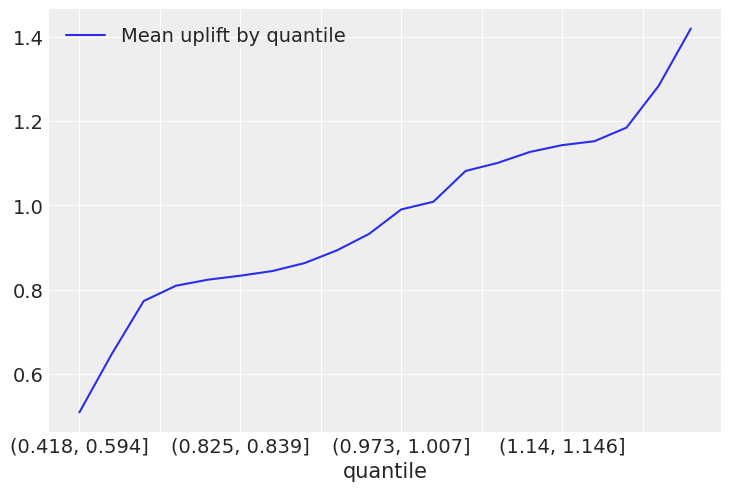

In [4]:
%%time
tlearner = TLearner(X=X, y=y, treated=treated, model=HistGradientBoostingRegressor())

summarize_learner(tlearner)

# X-learner
The X-learner was first introduced in [[1]](https://arxiv.org/abs/1706.03461) by
Similarly, to the T-learner, the X-learner first estimates $\mu_{\operatorname{treated}}$ and $\mu_{\operatorname{untreated}}$. Next, it computes 

$$D(1) := Y(1) - \hat{\mu}_{\operatorname{untreated}}(X(1)), \quad \text{and} \quad D(0) = \hat{\mu}_{\operatorname{treated}}(X(0)) - Y(0).$$

Note that if $\hat{\mu}_{\operatorname{untreated}} = \mu_{\operatorname{untreated}}$ and $\hat{\mu}_{\operatorname{treated}} = \mu_{\operatorname{treated}}$, then $\tau(x) = \mathbb{E}[D(1) | X=x] = \mathbb{E}[D(0) | X=x]$, so CATE may be estimated by regressing on $D(0)$ or $D(1)$. Let us denote the estimations obtained this way by $\tau_0$ and $\tau_1$, respectively. 

Finally, the X-learner computes a weighted average of the two CATE estimates, that is 
$$\hat{\tau}_X(x) = g(x)\hat{\tau}_0 + (1 - g(x))\hat{\tau_1}(x),$$
for some weight function $g: \mathbb{R}^d \rightarrow [0, 1]$.

In CausalPy, we obtain $g$ as an estimation of the so-called *propensity score*, that is the conditional probability of a unit receiving treatment given $X$. By default, we use logistic regression to obtain this estimation. However, in case one of the treatement groups is small, it makes sense to set $g \equiv 0$ or $g \equiv 1$.

Number of observations:             100
Number of treated observations:     26
Average treatement effect (ATE):    0.8837881368411192
95% Confidence interval for ATE:    (0.7604194149047154, 1.0213360451924018)
Estimated bias:                     -0.015952518856480535
---- Score  ----
{'treated': -0.022718608616440372, 'untreated': 0.4615650975283646, 'propensity': 0.74, 'treated_cate': -0.01508932784396233, 'untreated_cate': 0.46156509752836483}
Actual average treatement effect: 0.8455644128466571
MSE: 0.0035833820875945765
CPU times: total: 3min 38s
Wall time: 29 s


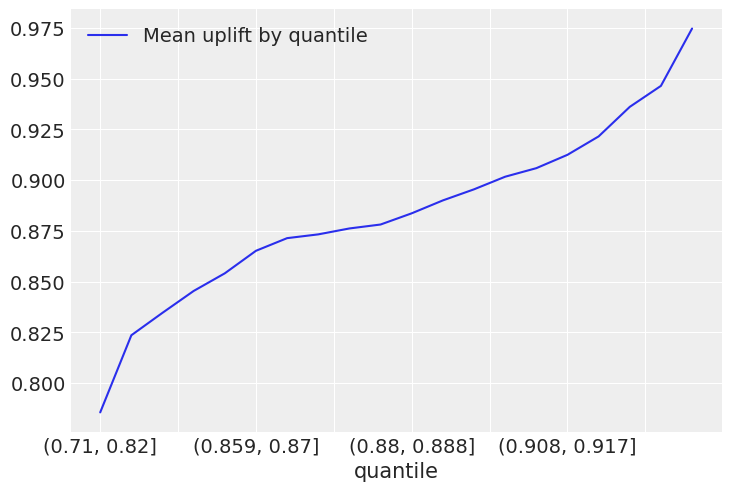

In [5]:
%%time
# Using logistic regression based propensity score
xlearner = XLearner(X=X, y=y, treated=treated, model=HistGradientBoostingRegressor())

summarize_learner(xlearner)

Number of observations:             100
Number of treated observations:     26
Average treatement effect (ATE):    0.8615441480227912
95% Confidence interval for ATE:    (0.8619040475980911, 0.9780900167241081)
Estimated bias:                     -0.016991817144321627
---- Score  ----
{'treated': -0.07111924089890742, 'untreated': 0.5176039158889738, 'propensity': 0.74, 'treated_cate': -0.052085096064813374, 'untreated_cate': 0.517603915888974}
Actual average treatement effect: 0.8455644128466571
MSE: 0.004913496827435016
CPU times: total: 3min 28s
Wall time: 27.5 s


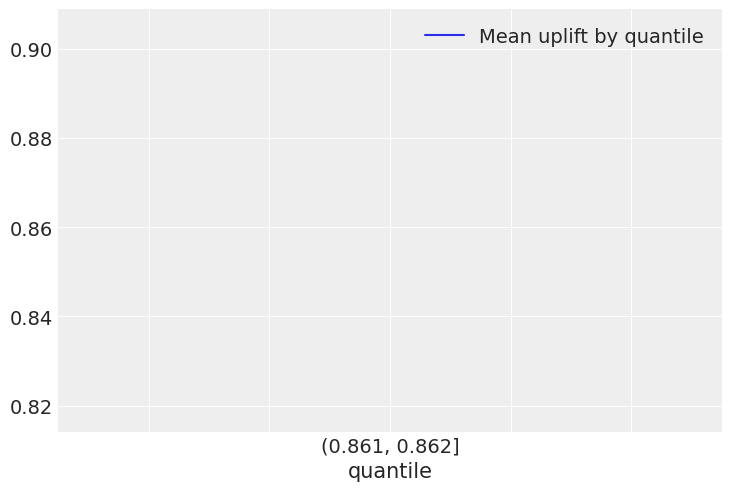

In [6]:
%%time
# Using constant g
xlearner_mf = XLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor(),
    propensity_score_model=DummyClassifier(strategy="most_frequent"),
)

summarize_learner(xlearner_mf)

# DR-learner

The *doubly-robust learner*, also known as the *DR-learner*, takes its name from the property that it is unbiased if either the propensity score estimator or the outcome regressions are correctly specified and it was first introduced in [[2]](https://arxiv.org/abs/2004.14497).

The DR-learner first splits the set of observations $S = (Y, X, W)$ randomly into two parts $S_i = (Y_i, X_i, W_i), i=1,2$ of equally many observations, finds the estimates $\hat{\mu}_{\operatorname{treated}}$, $\hat{\mu}_{\operatorname{untreated}}$ and $g$ on $S_1$. Then it constructs 

$$\varphi(X) = \frac{W - g(X)}{g(X)(1 - g(X))}(Y - \hat{\mu}_{W}(X)) + \hat{\mu}_{\operatorname{treated}} - \hat{\mu}_{\operatorname{untreated}}$$
called the *pseudo-outcome*, where $\hat{\mu}_W(X) = (1 - W)\hat{\mu}_{\operatorname{untreated}} + W\hat{\mu}_{\operatorname{treated}}$. Finally, regressing $\varphi(X_2)$ on $X_2$ yields the CATE estimator $\hat{\tau}_{DR}$. Optionally, one may perform a *cross-fitting step* by swapping the roles of $S_1$ and $S_2$ obtaining a second estimator. Averaging the two estimators usually results in a better one.

Number of observations:             100
Number of treated observations:     26
Average treatement effect (ATE):    0.9172354454463756
95% Confidence interval for ATE:    (0.691107742990425, 1.5065847599391242)
Estimated bias:                     0.03131311626014071
---- Score  ----
{'treated': -0.009335753981434936, 'untreated': -0.0006342347399423964, 'propensity': 0.74, 'pseudo-outcome': 0.015108882815612734}
Actual average treatement effect: 0.8455644128466571
MSE: 0.04738912217493377
CPU times: total: 2min 13s
Wall time: 17.5 s


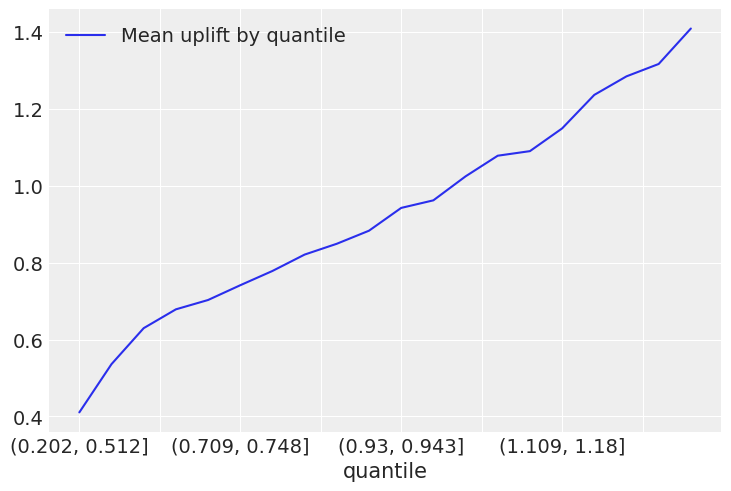

In [7]:
%%time
drlearner = DRLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor(),
    propensity_score_model=DummyClassifier(),
)

summarize_learner(drlearner)

Number of observations:             100
Number of treated observations:     26
Average treatement effect (ATE):    0.9422325586455574
95% Confidence interval for ATE:    (0.6719756565007992, 1.3349122961116073)
Estimated bias:                     -0.03275843981803161
---- Score  ----
{'treated': -7.045901399438392e-05, 'untreated': -0.07354364375362898, 'propensity': 0.74, 'pseudo-outcome': -0.003368392413228616}
Actual average treatement effect: 0.8455644128466571
MSE: 0.03459741914128395
CPU times: total: 4min 21s
Wall time: 35.9 s


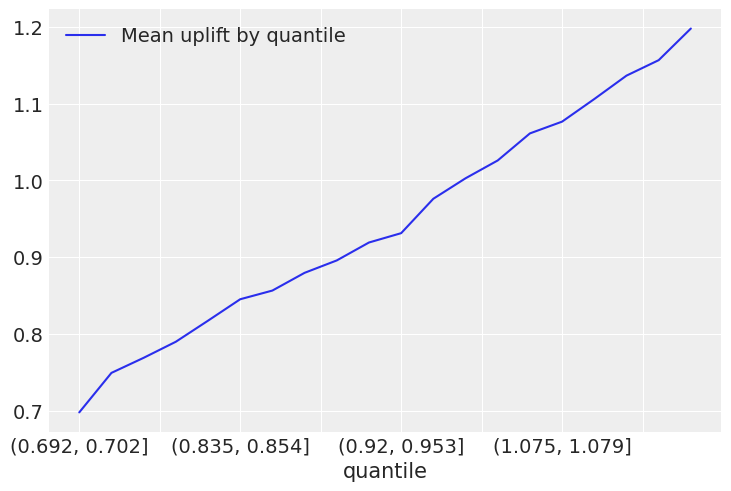

In [8]:
%%time
drlearner = DRLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor(),
    propensity_score_model=DummyClassifier(),
    cross_fitting=True,
)

summarize_learner(drlearner)

In [9]:
def compute_mse(learner, m):
    l = learner(X, y, treated, m)
    return mean_squared_error(treatment_effect, l.cate)


models = [
    ("Random forest", RandomForestRegressor()),
    ("Hist gradient boosting", HistGradientBoostingRegressor()),
    ("AdaBoost", AdaBoostRegressor()),
    ("XGBoost", XGBRegressor()),
    ("SVR", SVR()),
]

learners = [
    ("S-learner", SLearner),
    ("T-learner", TLearner),
    ("X-learner", XLearner),
    ("DR-learner", DRLearner),
    ("Cross-fitted DR-learner", lambda *args: DRLearner(*args, cross_fitting=True)),
]
bench = pd.DataFrame(
    {
        m_name: {
            learner_name: compute_mse(learner, m) for learner_name, learner in learners
        }
        for m_name, m in models
    }
)

<AxesSubplot:>

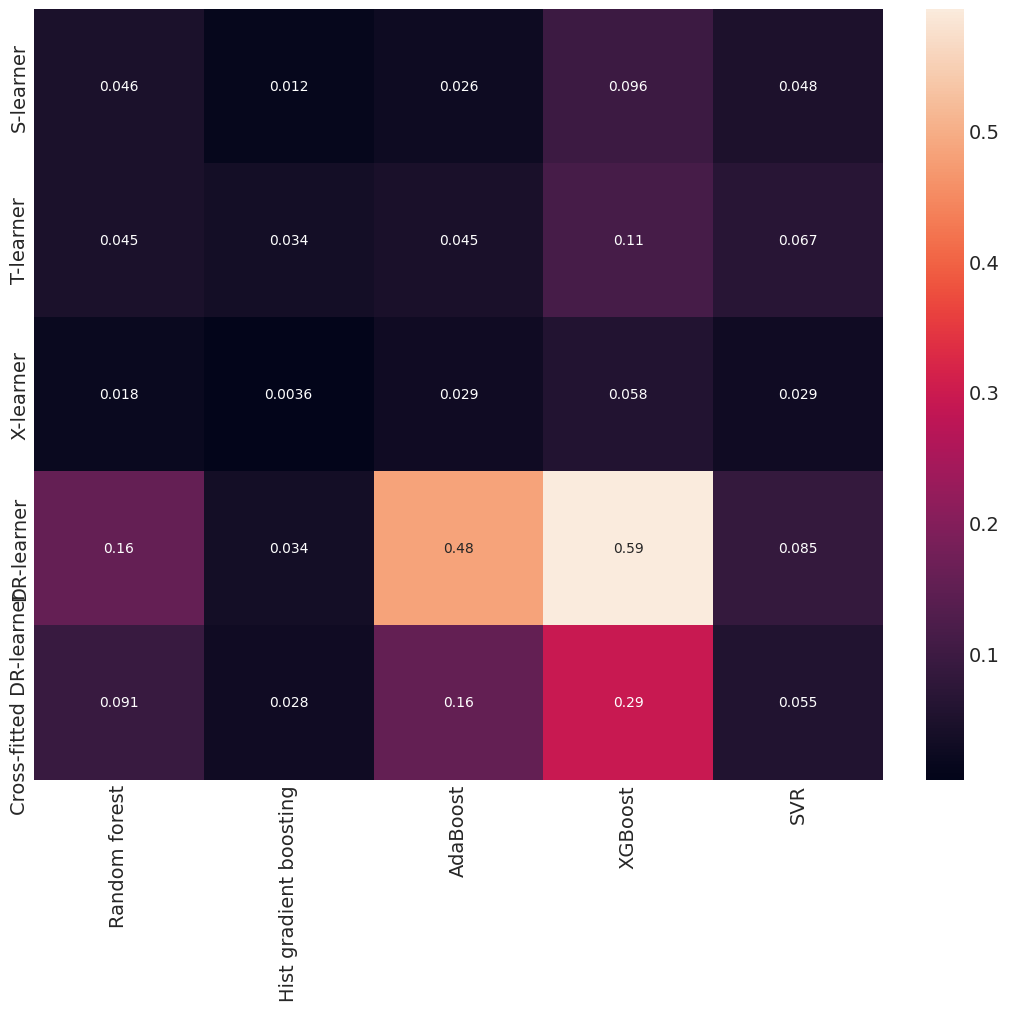

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(bench, annot=True, ax=ax)

Bibliography:

[1] Künzel, S. R., Sekhon, J. S., Bickel, P. J., and Yu, B. Metalearners for estimating heterogeneous treatment effects using machine learning. Proceedings of the national academy of sciences 116, no. 10 (2019): 4156-4165.

[2] Kennedy, E. H. Optimal doubly robust estimation of heterogeneous causal effects. arXiv preprint (2020) arXiv:2004.14497.

[3] Alves, M. F. Causal Inference for The Brave and True. [https://matheusfacure.github.io/python-causality-handbook](https://matheusfacure.github.io/python-causality-handbook).